DeePyMoD ODE Example

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
import training_adapted
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat


import torch
# from torch.autograd import grad
# from itertools import combinations
# from functools import reduce
# from typing import Tuple
# from deepymod.utils.types import TensorList
# from deepymod.model.library import Library
import libraryODE

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(30)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


# Preparing a new dataset
Firstly we prepare the dataset.
Therfore we load the time series from csv file and transform it into a Dataset object.

The "TS_3DLV" dataset contains an artificial time series generated by a tri-trophic Lotka-Volterra ODE system from https://github.com/WillemBonnaffe/NODEBNGM/tree/main.

Specify the number of species n_species in the given dataset and the order of interactions for the library:

In [2]:
# n_species = None
n_species = 3

# path of data file
filename = "TS_3DLV.csv"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/Literatur/Code/NODEBNGM/data/" + filename

# data should be of the form:
# [n_samples, (1 + n_species)]
# where the first colum contains the time t

# order of interactions included in the model (2 or 3)
int_order = 3

In [3]:
def create_data_fromCSV():
  data = np.genfromtxt(filepath, delimiter=";")
  usol = data[1:, :]
  ts = usol[:, 0]
  data_y = usol[:, 1:(1 + n_species)]
  T = torch.from_numpy(ts.reshape(-1, 1)).float()
  Y = torch.from_numpy(data_y).float()
  print("The coodinates have shape {}".format(T.shape))
  print("The data has shape {}".format(Y.shape))
  return T, Y

In [4]:
# show what the dataset looks like
data = create_data_fromCSV()
print("Time:", data[0][0:10])
print("Data:", data[1][0:10])

The coodinates have shape torch.Size([101, 1])
The data has shape torch.Size([101, 3])
Time: tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])
Data: tensor([[1.0000, 1.5000, 0.2500],
        [0.1915, 0.8081, 0.5061],
        [0.0959, 0.2496, 0.3533],
        [0.1255, 0.0900, 0.1747],
        [0.2404, 0.0423, 0.0853],
        [0.5075, 0.0280, 0.0480],
        [1.0023, 0.0283, 0.0340],
        [1.6552, 0.0416, 0.0303],
        [2.2046, 0.0773, 0.0318],
        [2.4697, 0.1592, 0.0375]])


In [5]:
# get number of samples in the data
n_samples = len(data[0])

Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [6]:
# def custom_normalize(feature):
#         """minmax all features by their absolute maximum
#         Args:
#             feature (torch.tensor): data to be minmax normalized
#         Returns:
#             (torch.tensor): minmaxed data"""
#         return (feature/feature.abs().max(axis=0).values)

In [7]:
# # add noise to dataset
# dataset = Dataset(
#     create_data_fromCSV,
#     subsampler=Subsample_random,
#     subsampler_kwargs={"number_of_samples": n_samples},
#     preprocess_kwargs={
#         "noise_level": 0.01,
#         "normalize_coords": False,
#         "normalize_data": False,
#     },
#     apply_normalize=custom_normalize,
#     device=device
# )

In [8]:
dataset = Dataset(
    create_data_fromCSV,
    device = device,
)

The coodinates have shape torch.Size([101, 1])
The data has shape torch.Size([101, 3])
Dataset is using device:  cpu


Visualization of the dataset

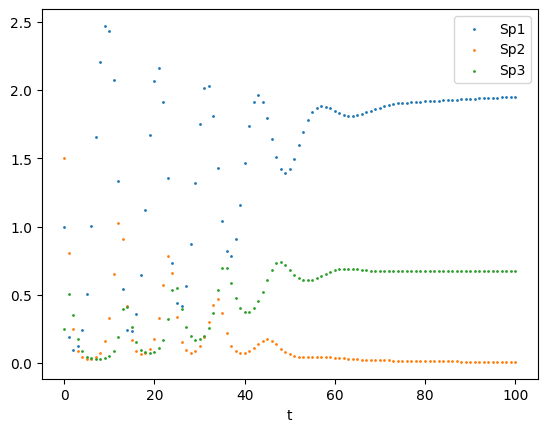

In [9]:
fig, ax = plt.subplots()
for i in np.arange(n_species):
    # plt.plot(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}")
    ax.scatter(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}", s=1)
ax.set_xlabel("t")
ax.legend()
# ax.set_title("Sampled and standardized data")
# plt.xlim([0,100])

Now we need to split our data into a train and test dataloaders for PyTorch

In [10]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [11]:
network = NN(1, [30, 30, 30, 30], n_species)

Configuration of the library function.

In [12]:
library = libraryODE.LibraryODE(int_order = int_order, intercept = False)

Show a list of the expressions contained in the library.

In [13]:
# get a list of coefficients contained in the library
library_values = library.get_content(dataset.data)

# number of coefficients per taxon
n_coefs = len(library_values[0])

# print the list
library_values

[['x1*1',
  'x1*x1',
  'x1*x2',
  'x1*x3',
  'x1*x1*x1',
  'x1*x1*x2',
  'x1*x1*x3',
  'x1*x2*x2',
  'x1*x2*x3',
  'x1*x3*x3'],
 ['x2*1',
  'x2*x1',
  'x2*x2',
  'x2*x3',
  'x2*x1*x1',
  'x2*x1*x2',
  'x2*x1*x3',
  'x2*x2*x2',
  'x2*x2*x3',
  'x2*x3*x3'],
 ['x3*1',
  'x3*x1',
  'x3*x2',
  'x3*x3',
  'x3*x1*x1',
  'x3*x1*x2',
  'x3*x1*x3',
  'x3*x2*x2',
  'x3*x2*x3',
  'x3*x3*x3']]

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [14]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [15]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [16]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

Defining optimizer

In [17]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

 41050  MSE: 2.93e-04  Reg: 7.96e-05  L1: 3.53e+01 

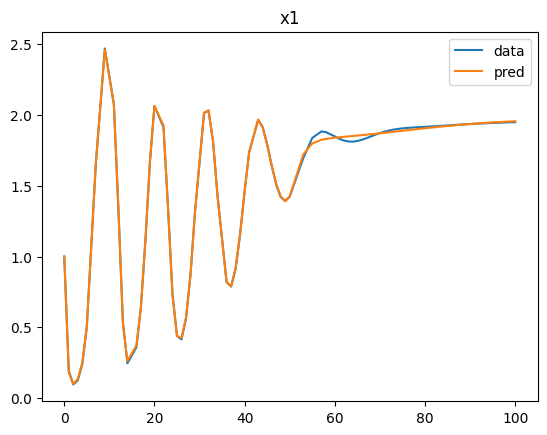

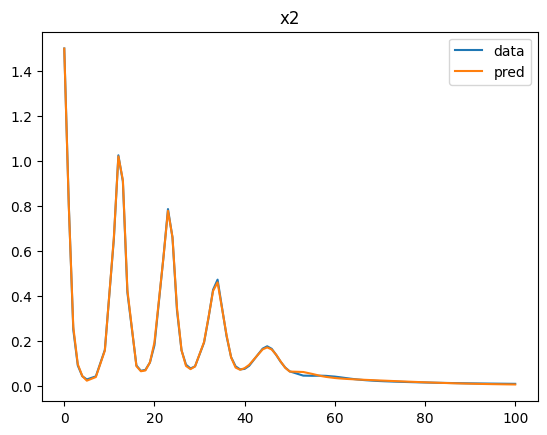

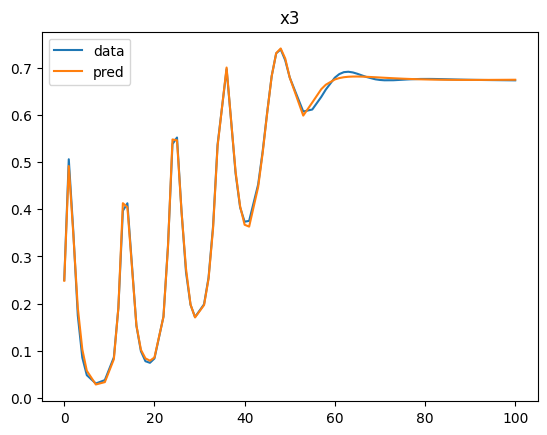

Algorithm converged. Writing model to disk.


In [18]:
# train(
training_adapted.train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="/data/deepymod/ODE_S3_DLV/",
    max_iterations=50000,
    delta=1e-3,
    patience=100,
)

Now that DeepMoD has converged, it has found the following coefficients to not be zero:

In [19]:
model.sparsity_masks

[tensor([ True,  True,  True,  True,  True,  True,  True, False, False,  True]),
 tensor([True, True, True, True, True, True, True, True, True, True]),
 tensor([ True,  True,  True, False, False,  True, False,  True,  True, False])]

And it found the following coefficients.

In [20]:
model.estimator_coeffs()

[array([[ 4.332195  ],
        [-1.2002095 ],
        [-2.1352408 ],
        [-2.1694076 ],
        [-1.1058971 ],
        [ 0.90855056],
        [ 0.73610634],
        [ 0.        ],
        [ 0.        ],
        [-0.19886531]], dtype=float32),
 array([[-1.0771743 ],
        [ 2.3419695 ],
        [-1.1818233 ],
        [-1.3228059 ],
        [-0.6557942 ],
        [ 0.34926513],
        [ 0.13481335],
        [ 0.69425887],
        [ 0.56916744],
        [ 0.22369702]], dtype=float32),
 array([[-2.7477455],
        [ 2.4155643],
        [-1.3050958],
        [ 0.       ],
        [ 0.       ],
        [ 0.79497  ],
        [ 0.       ],
        [ 1.0552901],
        [ 0.7833832],
        [ 0.       ]], dtype=float32)]

## Analysis/Visualization of the train() loss

In [21]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

In [22]:
# # get list of all output values that were calculated during train()
# os.listdir("/data/deepymod/ODE_S3_DLV/")

In [23]:
tmp_file = os.listdir("/data/deepymod/ODE_S3_DLV/loss_mse_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S3_DLV/loss_mse_output_0/" + tmp_file

train_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        train_loss = np.append(train_loss, mse)
        i += 1

# train_loss

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [24]:
tmp_file = os.listdir("/data/deepymod/ODE_S3_DLV/remaining_MSE_test_val_0/")[-1]
file_dir = "/data/deepymod/ODE_S3_DLV/remaining_MSE_test_val_0/" + tmp_file

test_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        test_loss = np.append(test_loss, mse)
        i += 1

# test_loss

In [25]:
tmp_file = os.listdir("/data/deepymod/ODE_S3_DLV/loss_l1_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S3_DLV/loss_l1_output_0/" + tmp_file

l1_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        l1_loss = np.append(l1_loss, mse)
        i += 1

# l1_loss

In [26]:
tmp_file = os.listdir("/data/deepymod/ODE_S3_DLV/loss_reg_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S3_DLV/loss_reg_output_0/" + tmp_file

reg_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        reg_loss = np.append(reg_loss, mse)
        i += 1

# reg_loss

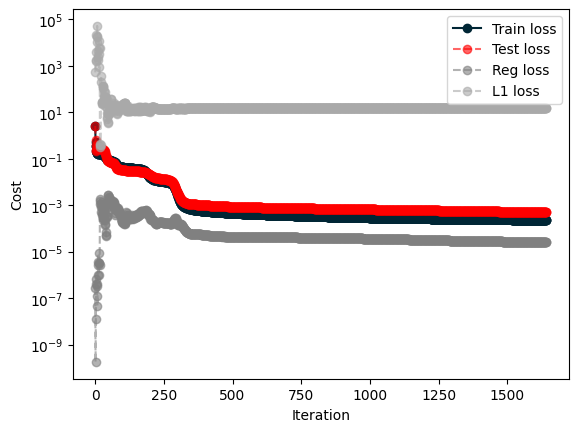

In [27]:
fig, ax = plt.subplots()
ax.plot(train_loss, c='#002635', marker='o', label='Train loss')
ax.plot(test_loss, c='red', marker='o', ls='--', alpha=0.6, label='Test loss')
ax.plot(reg_loss, c='gray', marker='o', ls='--', alpha=0.6, label='Reg loss')
ax.plot(l1_loss, c='darkgray', marker='o', ls='--', alpha=0.6, label='L1 loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend()
# plt.xlim([0, 500])

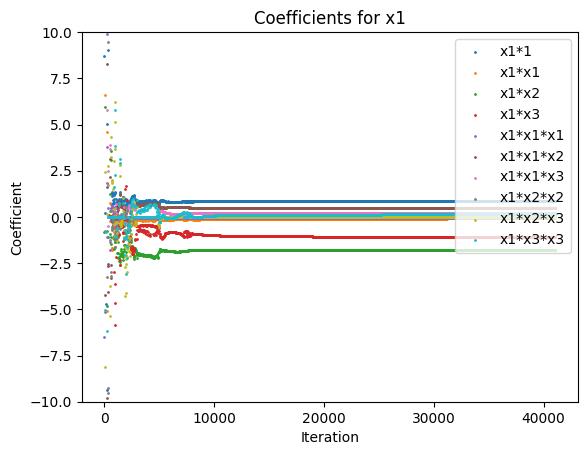

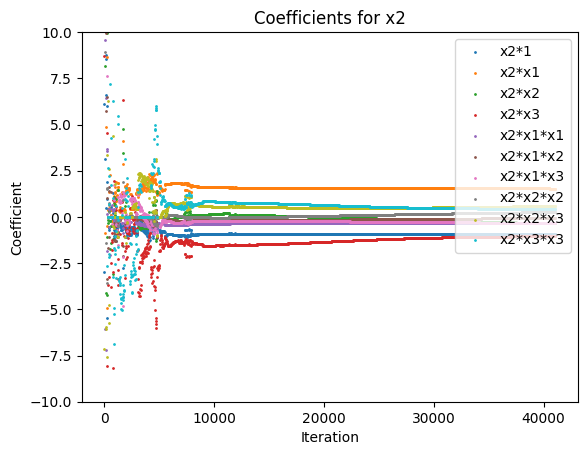

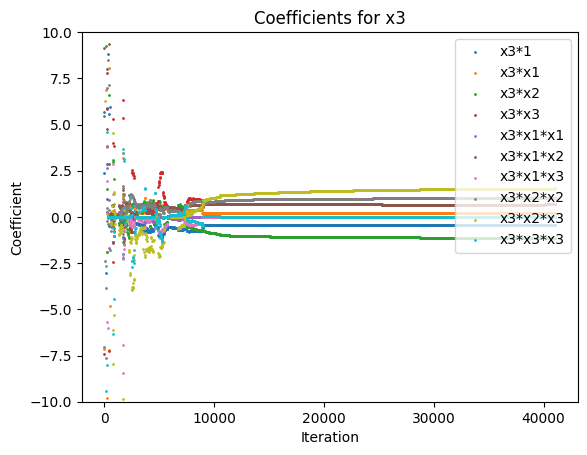

In [29]:
for taxon in np.arange(n_species):
    output = []

    for coef in np.arange(n_coefs):
        folder_dir = f"/data/deepymod/ODE_S3_DLV/unscaled_coeffs_output_{taxon}_coeff_{coef}/"
        tmp_file = os.listdir(folder_dir)[-1]
        file_dir = folder_dir + tmp_file

        output_coef = np.array([])
        i = 0
        # os.listdir(file_dir)
        for summary in summary_iterator(file_dir):
            for value in summary.summary.value:
                # Extract relevant information from the event
                coef_val = value.simple_value
                output_coef = np.append(output_coef, coef_val)
                i += 1
        output.append(output_coef)

    n_iteration = len(output[0])

    fig, ax = plt.subplots()
    for coef in np.arange(n_coefs):
        # ax.plot(output[coef], marker='o', ls='--', alpha=0.6, label=f'Coef {coef}')
        ax.scatter(np.arange(25*n_iteration, step = 25), output[coef], label = f'{library_values[taxon][coef]}', s=1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Coefficient')
    ax.set_title(f'Coefficients for x{taxon+1}')
    ax.legend(loc = "upper right")
    # plt.xlim([0, 6000])
    plt.ylim([-10, 10])